<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/NMA-22-DL-Saltenas-Project/blob/main/Saltenas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import os, requests
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import gzip

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

DEVICE = 'cuda'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
mice = np.unique(pd.DataFrame(np.array(os.listdir('/content/drive/MyDrive/Mouse_Data/')))[0].apply(lambda x: x[0:15]))
print(mice)

['Slc_mouse461946' 'Slc_mouse462468' 'Slc_mouse462544' 'Slc_mouse464204'
 'Slc_mouse464207' 'Sst_mouse470784' 'Sst_mouse476970' 'Sst_mouse477202'
 'Sst_mouse480753' 'Sst_mouse485688' 'Sst_mouse489056' 'Sst_mouse498972'
 'Vip_mouse467951' 'Vip_mouse467953' 'Vip_mouse467954' 'Vip_mouse489066'
 'Vip_mouse492395']


In [40]:
# Function to load in data from mounted drive on Colab
def load_gzip_arrays(fn, dir = '/content/drive/MyDrive/Mouse_Data/'):
    f = gzip.GzipFile(dir+fn+'_label.npy.gz', "r")
    label_data = np.load(f,allow_pickle=True)
    label_data = pd.DataFrame(label_data,columns=['image_name','is_change','omitted','session_number'])

    f = gzip.GzipFile(dir+fn+'_dffbc.npy.gz', "r")
    dff_bc = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffstim.npy.gz', "r")
    dff_stim = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffts.npy.gz', "r")
    dff_ts = np.load(f)

    return label_data, dff_bc, dff_stim, dff_ts

score_test = {}
score_train = {}
score_out = {}

# Select a mouse
area = 'Slc'
vip_mouse_id = [467951, 467953, 467954, 489066, 492395]
sst_mouse_id = [470784, 476970, 477202, 480753, 485688, 489056, 498972]
slc_mouse_id = [461946, 462468, 462544, 464204, 464207]

mouse_id = slc_mouse_id[1]

fn = f'{area}_mouse{mouse_id}'
label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)

In [45]:
# Possible subsetting groups
not_omitted = np.logical_not(label_data['omitted'])
familiar = label_data['session_number']<=3
novel = label_data['session_number']>3
passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
active = np.logical_not(passive)
is_change = label_data['is_change']
not_change = np.logical_not(is_change)

# Choose a subset
subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))

subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))

len(subset[0])

12966

In [46]:
class NetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num):
    super(NetDropout, self).__init__()
    self.fc1 = nn.Linear(input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)
    #self.dropout1 = nn.Dropout(0.5)
    #self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    #x = F.leaky_relu(self.dropout1(self.fc3(x)))
    #x = F.leaky_relu(self.dropout1(self.fc4(x)))
    output = self.fc3(x)
    return output

In [95]:
# Prepare input data (mean firing rates: dff_bc or dff_stim)
def prepare_data(dff_mat, trial_subset, cell_subset = None):
  if len(dff_mat.shape)==3:
    X = dff_bc[trial_subset,:,:].squeeze()
    if cell_subset==None:
      cell_subset = np.where(X.sum(axis=0).sum(axis=1)!=0)
    X = X[:,cell_subset,:].squeeze()
    X = np.nan_to_num(X)
    y = label_data.loc[trial_subset,'image_name']
    _, y = np.unique(y, return_inverse=True)

  elif len(dff_mat.shape)==2:
    X = dff_bc[trial_subset,:].squeeze()
    if cell_subset==None:
      cell_subset = np.where(X.sum(axis=0)!=0)
    X = X[:,cell_subset].squeeze()
    X = np.nan_to_num(X)
    y = label_data.loc[trial_subset,'image_name']
    _, y = np.unique(y, return_inverse=True)

  else:
    print('Error: dff_mat must be 2D or 3D')

  return X, y, cell_subset

X, y, cell_subset = prepare_data(dff_bc, subset)
X2, y2, _ = prepare_data(dff_bc, subset2, cell_subset)

In [89]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

# Initialize network
net = NetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()
X_train = torch.Tensor(X_train).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

In [90]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)

net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test).to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.9321511179645335
Out score: 0.30963302752293576


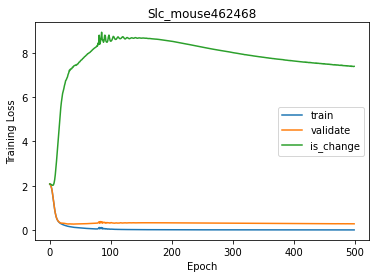

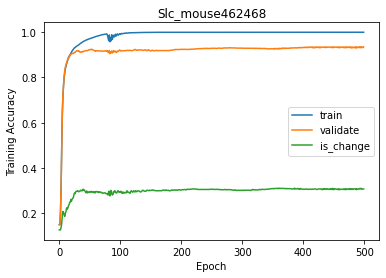

In [91]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')

In [56]:
class ConvNetDropout(nn.Module):
  """
  """

  def __init__(self,input_feature_num):
    super(ConvNetDropout, self).__init__()
    filters_num = 1
    self.conv = nn.Conv1d(input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    #self.pool = nn.AdaptiveAvgPool1d(1)
    self.fc1 = nn.Linear(filters_num*input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)

  def forward(self, x):
    x0 = self.conv(x)
    #x1 = torch.squeeze(self.pool(x0))
    x1 = torch.amax(x0,2)
    x2 = F.leaky_relu(self.fc1(x1))
    x3 = F.leaky_relu(self.fc2(x2))
    output = self.fc3(x3)
    return output

In [57]:
# Prepare input data (time series firing rates)
X, y, cell_subset = prepare_data(dff_ts, subset)
X2, y2, _ = prepare_data(dff_ts, subset2, cell_subset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

X_train = torch.Tensor(X_train).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

# Initialize
net = ConvNetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)
net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test)
  yhat_val = yhat_val.to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  # _, yhat_train = torch.max(yhat_train, 1)
  # score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)

Training score: 0.5272573124205172
Test score: 0.17543859649122806
Out score: 0.14112903225806453


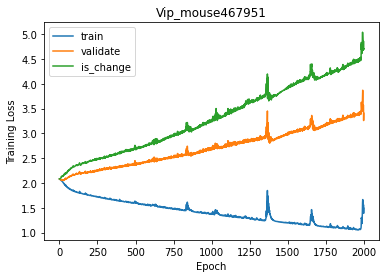

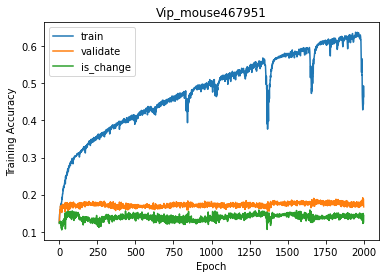

In [37]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')